Train: 76483, Val: 21852, Test: 10927
类别权重: tensor([0.6560, 0.0058, 0.0657, 0.1998, 0.0727])
Epoch [1/50]
  Train -> Acc: 64.90% | Loss: 0.0081
  Val   -> Acc: 91.41% | Loss: 0.0046
  ✅ Best model saved (state_dict).
Epoch [2/50]
  Train -> Acc: 83.86% | Loss: 0.0039
  Val   -> Acc: 92.02% | Loss: 0.0029
  ✅ Best model saved (state_dict).
Epoch [3/50]
  Train -> Acc: 88.47% | Loss: 0.0027
  Val   -> Acc: 86.34% | Loss: 0.0026
  ✅ Best model saved (state_dict).
Epoch [4/50]
  Train -> Acc: 89.52% | Loss: 0.0023
  Val   -> Acc: 91.70% | Loss: 0.0018
  ✅ Best model saved (state_dict).
Epoch [5/50]
  Train -> Acc: 91.65% | Loss: 0.0017
  Val   -> Acc: 90.66% | Loss: 0.0021
  No improvement.
Epoch [6/50]
  Train -> Acc: 92.25% | Loss: 0.0016
  Val   -> Acc: 92.98% | Loss: 0.0016
  ✅ Best model saved (state_dict).
Epoch [7/50]
  Train -> Acc: 92.72% | Loss: 0.0013
  Val   -> Acc: 92.83% | Loss: 0.0015
  ✅ Best model saved (state_dict).
Epoch [8/50]
  Train -> Acc: 93.10% | Loss: 0.0012
  Val

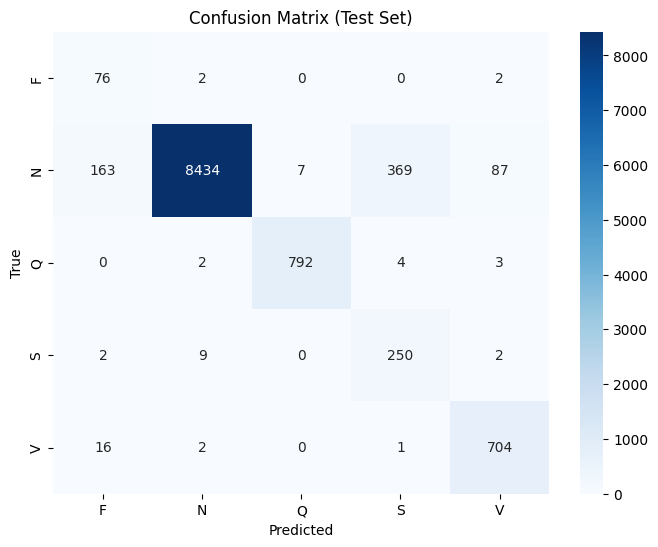

(ECG_CNN(
   (conv1): Conv1d(1, 4, kernel_size=(21,), stride=(1,), padding=(10,))
   (pool1): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (conv2): Conv1d(4, 16, kernel_size=(23,), stride=(1,), padding=(11,))
   (pool2): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (conv3): Conv1d(16, 32, kernel_size=(25,), stride=(1,), padding=(12,))
   (pool3): AvgPool1d(kernel_size=(3,), stride=(2,), padding=(1,))
   (conv4): Conv1d(32, 64, kernel_size=(27,), stride=(1,), padding=(13,))
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (fc1): Linear(in_features=2432, out_features=128, bias=True)
   (dropout): Dropout(p=0.2, inplace=False)
   (fc2): Linear(in_features=128, out_features=5, bias=True)
 ),
 {'train_acc': [64.89677444660904,
   83.86177320450297,
   88.47325549468509,
   89.52185452976478,
   91.65435456245179,
   92.24533556476602,
   92.71602839846763,
   93.099120065897,
   93.9306774054365,
   94.01958605180236,
   94.

In [6]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score,recall_score, precision_score
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
# 读取数据
data = pd.read_csv('/kaggle/input/mit-bih-data/ECG_data.csv')

# 提取信号和标签
signals = data['Signal'].apply(lambda x: np.fromstring(x[1:-1], sep=',')).values
labels = data['Label'].values
signals = np.array([np.array(signal) for signal in signals])

# 标签编码
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

X_train, X_temp, y_train, y_temp = train_test_split(
    signals, labels_encoded, test_size=0.3, random_state=42, stratify=labels_encoded)

# 第二步：将临时集中的 2/3 设为验证集（20%），1/3 设为测试集（10%）
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)

# 检查划分比例
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# 扩展维度
X_train = np.expand_dims(X_train, axis=1)
X_val = np.expand_dims(X_val, axis=1)
X_test = np.expand_dims(X_test, axis=1)

# 转换为Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 创建DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


# 定义CNN模型
class ECG_CNN(nn.Module):
    def __init__(self):
        super(ECG_CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=4, kernel_size=21, stride=1, padding=10)
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(in_channels=4, out_channels=16, kernel_size=23, stride=1, padding=11)
        self.pool2 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=25, stride=1, padding=12)
        self.pool3 = nn.AvgPool1d(kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=27, stride=1, padding=13)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 38, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = torch.relu(self.conv4(x))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        """
        Focal Loss 构造函数.
        alpha: 平衡正负样本的权重，可以是 float 或类别权重的 tensor.
        gamma: 难易样本的聚焦因子.
        reduction: 损失的降维方式, 可选 'none', 'mean', 'sum'.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        """
        计算 Focal Loss.
        logits: 模型输出 (batch_size, num_classes).
        targets: 真实标签 (batch_size).
        """
        # 转换为概率
        probs = torch.softmax(logits, dim=-1)  # (batch_size, num_classes)

        # 将目标转为 one-hot
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=logits.size(-1)).float()  # (batch_size, num_classes)
        probs_true = (probs * targets_one_hot).sum(dim=1)  # (batch_size)

        # 焦点权重
        focal_weight = (1.0 - probs_true) ** self.gamma  # (batch_size)

        # 处理 alpha，支持类别权重或单一值
        if isinstance(self.alpha, torch.Tensor):
            alpha_factor = self.alpha[targets]  # 从类别权重中取出对应值 (batch_size)
        else:
            alpha_factor = self.alpha  # 单一权重值 (float)

        # 计算交叉熵损失
        log_probs = torch.log(probs_true + 1e-12)  # 避免 log(0)
        loss = -alpha_factor * focal_weight * log_probs  # (batch_size)

        # 根据 reduction 选项处理损失
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:  # 'none'
            return loss



# 计算类别权重
unique_labels, label_counts = np.unique(y_train, return_counts=True)
class_weights = torch.tensor([1.0 / count for count in label_counts], dtype=torch.float32)
class_weights /= class_weights.sum()  # 归一化权重
print("类别权重:", class_weights)

# 初始化模型
model = ECG_CNN()

# 定义Focal Loss和优化器
criterion = FocalLoss(alpha=class_weights, gamma=2.0, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.001)


def compute_test_metrics(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []
    
    start_time = time.time()  # ✅ 开始计时
    with torch.no_grad():
        for data, target in data_loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    end_time = time.time()  # ✅ 结束计时
    elapsed_time = end_time - start_time
    accuracy = 100 * correct / total
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    sensitivity = recall_score(all_targets, all_predictions, average='weighted')
    precision = precision_score(all_targets, all_predictions, average='weighted')

    conf_matrix = confusion_matrix(all_targets, all_predictions)
    tn = conf_matrix.sum() - conf_matrix.sum(axis=0) - conf_matrix.sum(axis=1) + np.diagonal(conf_matrix)
    fp = conf_matrix.sum(axis=0) - np.diagonal(conf_matrix)
    specificity_per_class = tn / (tn + fp + 1e-6)
    samples_per_class = conf_matrix.sum(axis=1)
    total_samples = np.sum(samples_per_class)
    specificity = np.sum((samples_per_class / total_samples) * specificity_per_class)

    return accuracy, f1, sensitivity, precision, specificity, conf_matrix,elapsed_time

def plot_acc_loss(history):
    epochs = range(1, len(history['train_acc']) + 1)

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)', color='tab:blue')
    ax1.plot(epochs, history['train_acc'], label='Train Accuracy', color='tab:blue', linestyle='-')
    ax1.plot(epochs, history['val_acc'], label='Val Accuracy', color='tab:blue', linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(90,100)
    ax1.grid(True)
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Loss', color='tab:red')
    ax2.plot(epochs, history['train_loss'], label='Train Loss', color='tab:red', linestyle='-')
    ax2.plot(epochs, history['val_loss'], label='Val Loss', color='tab:red', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0,0.03)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

    plt.title('Accuracy and Loss over Epochs')
    fig.tight_layout()
    plt.savefig("CNNs Accuracy_Loss Dual Axis.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()



def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs):
    history = {
        'train_acc': [], 'val_acc': [],
        'train_loss': [], 'val_loss': []
    }

    best_val_loss = float('inf')
    best_model_path = 'CNNs_best_model.pth'

    for epoch in range(num_epochs):
        # === Training ===
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # === Validation ===
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct_val / total_val
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train -> Acc: {train_acc:.2f}% | Loss: {train_loss:.4f}")
        print(f"  Val   -> Acc: {val_acc:.2f}% | Loss: {val_loss:.4f}")

        # === Save Best Model (based on validation loss) ===
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print("  ✅ Best model saved (state_dict).")
        else:
            print("  No improvement.")

    # === 重新加载最优模型进行测试 ===
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    # === 测试集评估 ===
    start_time = time.time()
    test_acc, test_f1, test_sen, test_ppv, test_spe, conf_matrix, test_time = compute_test_metrics(model, test_loader)
    test_time = time.time() - start_time

    print("\n=== Final Test Set Performance ===")
    print(f"Test Acc: {test_acc:.2f}% | F1: {test_f1:.4f} | Sensitivity: {test_sen:.4f} | "
          f"PPV: {test_ppv:.4f} | Specificity: {test_spe:.4f}")
    print(f"🕒 Inference Time on Test Set: {test_time:.2f} seconds")

    pd.DataFrame({
        'Accuracy (%)': [test_acc],
        'F1 Score': [test_f1],
        'Sensitivity': [test_sen],
        'Precision (PPV)': [test_ppv],
        'Specificity': [test_spe]
    }).to_csv("CNNs Test Metrics.csv", index=False)

    # 混淆矩阵图
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Test Set)")
    plt.savefig("CNNs Confusion Matrix.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()

    return model, history

train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=50)
        



